# Analysis for the experiments on the TSCP scenario

In [1]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from itertools import combinations

In [2]:
# Settings
fileName = "resultsTSCP.csv"
orderingStrategyPMedici = "IN_ORDER_SIZE_DESC"

In [3]:
# Load the file into a pandas dataframe
df = pd.read_csv(fileName, names=['Generator','ModelName','PercentageOfOldTsKept','TSSize','TSTime','Strength','Ordering'], header=0, index_col=False, delimiter=',')	
# Set Ordering to empty string where it is NaN
df['Ordering'].fillna('', inplace=True)

## Group all executions

In [4]:
# Group data in df by Generator, ModelName, PercentageOfOldTsKept, Strength, and Ordering. For the TSSize and TS time, take the mean
df = df.groupby(['Generator','ModelName','PercentageOfOldTsKept','Strength','Ordering']).agg({'TSSize':'mean', 'TSTime':'mean'}).reset_index()
# Remove from df all the lines where generator is pMEDICI or pMEDICI+ but Ordering is not equal to orderingStrategyPMedici
dfFiltered = df[~(df['Generator'].str.contains('pMEDICI')) | (df['Generator'].str.contains('pMEDICI') & (df['Ordering'] == orderingStrategyPMedici))]

In [5]:
# Count and print the number of timeouts per Generator
print(dfFiltered[dfFiltered['TSTime'] == -1].groupby(['ModelName','Generator']).agg({'TSTime':'count'}).reset_index().groupby(['Generator']).agg({'TSTime':'count'}))

           TSTime
Generator        
PICT           12
pMEDICI         5
pMEDICI+       10


In [7]:
# Set all timeouts (TSTime = -1) to TSTime = 300001 and with Size = MAX Size
dfFiltered.loc[dfFiltered['TSTime'] == -1, 'TSSize'] = 100000
dfFiltered.loc[dfFiltered['TSTime'] == -1, 'TSTime'] = 301000

# Remove all the rows corresponding to models for which at least one of the generators timed out
# dfFiltered = dfFiltered[~dfFiltered['ModelName'].isin(dfFiltered[dfFiltered['TSTime'] == 301000]['ModelName'])]

## How does the execution time change depending on the PercentageOfTsKept?

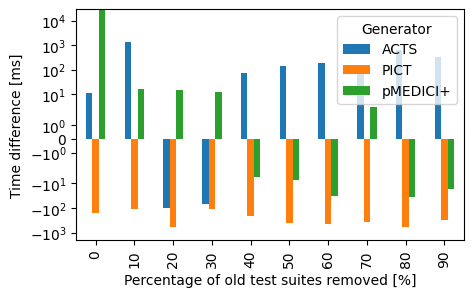

In [8]:
# Build a dataframe with for each model and PercentageOfOldTsKept the difference between the time required by the generator with PercentageOfOldTsKept = 100 and that with the selected PercentageOfOldTsKept
dfDiff = pd.DataFrame(columns=['ModelName','PercentageOfOldTsKept','TSTimeDiff', 'Generator'])
generators = {
    'ACTS' : 'ACTS',
    'PICT' : 'PICT',
    'pMEDICI+' : 'pMEDICI',
}
for generator in dfFiltered['Generator'].unique():
    if (generator == 'KALI' or generator == 'pMEDICI'):
        continue
    for modelName in dfFiltered['ModelName'].unique():
        for percentageOfOldTsKept in dfFiltered['PercentageOfOldTsKept'].unique():  
            if (percentageOfOldTsKept == 100):
                continue
            dfDiff.loc[len(dfDiff), dfDiff.columns] = {'ModelName':modelName, 
                                                    'PercentageOfOldTsKept':percentageOfOldTsKept, 
                                                    'Generator':generator,
                                                    'TSTimeDiff':dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == percentageOfOldTsKept) 
                                                                            & (dfFiltered['Generator'] == generator)]['TSTime'].iloc[0] 
                                                                 - 
                                                                 dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == 100) 
                                                                            & (dfFiltered['Generator'] == generators[generator])]['TSTime'].iloc[0]
                                                    }            

# Average the TSTimeDiff for each model over the different values of PercentageOfOldTsKept
dfDiff = dfDiff.groupby(['PercentageOfOldTsKept', 'Generator']).agg({'TSTimeDiff':'mean'}).reset_index()

# Barplot showing the distribution of the TSTimeDiff for each PercentageOfOldTsKept and for each Generator
ax = dfDiff.pivot(index='PercentageOfOldTsKept', columns='Generator', values='TSTimeDiff').plot.bar(figsize=(5,3))

# ax = dfDiff.sort_values(by = 'PercentageOfOldTsKept').plot.bar(x='PercentageOfOldTsKept', y='TSTimeDiff', figsize=(5,3))
ax.set_xlabel("Percentage of old test suites removed [%]")
ax.set_ylabel("Time difference [ms]")
ax.set_yscale('symlog')

plt.savefig("pictures/TSCP_TS_TimeDiff.pdf", bbox_inches='tight')

## How does the test suite size change depending on the PercentageOfTsKept?

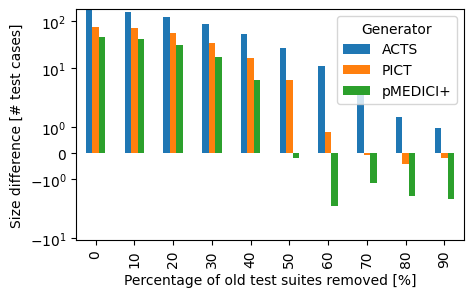

In [9]:
# Build a dataframe with for each model and PercentageOfOldTsKept the difference between the time required by the generator with PercentageOfOldTsKept = 100 and that with the selected PercentageOfOldTsKept
dfDiff = pd.DataFrame(columns=['ModelName','PercentageOfOldTsKept','TSSizeDiff', 'Generator'])
generators = {
    'ACTS' : 'ACTS',
    'PICT' : 'PICT',
    'pMEDICI+' : 'pMEDICI',
}
for generator in dfFiltered['Generator'].unique():
    if (generator == 'KALI' or generator == 'pMEDICI'):
        continue
    for modelName in dfFiltered[~dfFiltered['ModelName'].isin(dfFiltered[dfFiltered['TSTime'] == 301000]['ModelName'])]['ModelName'].unique():
        for percentageOfOldTsKept in dfFiltered['PercentageOfOldTsKept'].unique():
            if (percentageOfOldTsKept == 100):
                continue
            dfDiff.loc[len(dfDiff), dfDiff.columns] = {'ModelName':modelName, 
                                                    'PercentageOfOldTsKept':percentageOfOldTsKept, 
                                                    'Generator':generator,
                                                    'TSSizeDiff':dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == percentageOfOldTsKept) 
                                                                            & (dfFiltered['Generator'] == generator)]['TSSize'].iloc[0] 
                                                                 - 
                                                                 dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == 100) 
                                                                            & (dfFiltered['Generator'] == generators[generator])]['TSSize'].iloc[0]
                                                    }
        
# Average the TSTimeDiff for each model over the different values of PercentageOfOldTsKept
dfDiff = dfDiff.groupby(['PercentageOfOldTsKept', 'Generator']).agg({'TSSizeDiff':'mean'}).reset_index()

# Barplot showing the distribution of the TSTimeDiff for each PercentageOfOldTsKept and for each Generator
ax = dfDiff.pivot(index='PercentageOfOldTsKept', columns='Generator', values='TSSizeDiff').plot.bar(figsize=(5,3))

# ax = dfDiff.sort_values(by = 'PercentageOfOldTsKept').plot.bar(x='PercentageOfOldTsKept', y='TSTimeDiff', figsize=(5,3))
ax.set_xlabel("Percentage of old test suites removed [%]")
ax.set_ylabel("Size difference [# test cases]")

ax.set_yscale('symlog')

plt.savefig("pictures/TSCP_TS_SizeDiff.pdf", bbox_inches='tight')

## Timeouts analysis

In [10]:
# Count the number of timeouts for each tool and for each PercentageOfOldTsKept
dfTimeOuts = dfFiltered[dfFiltered['TSTime'] == 301000].groupby(['Generator','PercentageOfOldTsKept']).agg({'TSTime':'count'}).reset_index()
print (dfTimeOuts)

   Generator  PercentageOfOldTsKept  TSTime
0       PICT                      0      12
1       PICT                     10      12
2       PICT                     20      12
3       PICT                     30      12
4       PICT                     40      12
5       PICT                     50      12
6       PICT                     60      12
7       PICT                     70      12
8       PICT                     80      12
9       PICT                     90      12
10      PICT                    100      12
11   pMEDICI                    100       5
12  pMEDICI+                      0      10
13  pMEDICI+                     10       5
14  pMEDICI+                     20       5
15  pMEDICI+                     30       5
16  pMEDICI+                     40       5
17  pMEDICI+                     50       5
18  pMEDICI+                     60       5
19  pMEDICI+                     70       5
20  pMEDICI+                     80       5
21  pMEDICI+                    

## Summary data

In [11]:
# Print the average time and size for each Generator
dfSummary = dfFiltered[dfFiltered['PercentageOfOldTsKept'] == 80]
print(dfSummary.groupby(['Generator']).agg({'TSTime':'mean'}))
print(dfSummary[~dfSummary['ModelName'].isin(dfSummary[dfSummary['TSTime'] == 301000]['ModelName'])].groupby(['Generator']).agg({'TSSize':'mean'}))

              TSTime
Generator           
ACTS       10599.848
PICT       72709.548
pMEDICI+   32639.344
               TSSize
Generator            
ACTS        94.536842
PICT        96.610526
pMEDICI+   126.031579


## Analysis per tool and category

In [12]:
import seaborn as sns

def plotByCategory(dfFiltered, measure):
    dfFiltered2 = dfFiltered
        
    # Extract the execution time of different generators
    if (measure == 'Time'):
        dfExecution = dfFiltered2[['Generator','TSTime','PercentageOfOldTsKept']]
        yLabel = 'Execution time [ms]'
        yValue = 'TSTime'
    else:
        dfExecution = dfFiltered2[['Generator','TSSize','PercentageOfOldTsKept']]
        yLabel = 'Test Suite Size'        
        yValue = 'TSSize'
        
    dfExecution = dfExecution[~ (dfExecution['PercentageOfOldTsKept'] ==  100)]
    dfExecution = dfExecution[~ (dfExecution['Generator'] ==  'pMEDICI')]
    dfExecution = dfExecution[~ (dfExecution['Generator'] ==  'KALI')]

    # Boxplot the execution time of different generators and remove the outliers
    ax = sns.boxplot(x="PercentageOfOldTsKept", y=yValue,
            hue="Generator",
            data=dfExecution, showfliers=False)
    ax.set_yscale('log')
    ax.set_ylabel(yLabel)
    ax.set_xlabel('Percentage of old test suites removed [%]')
    ax.set_title('')
    
    # Highlight for each generator the best category
    colors = { 'ACTS': 'b', 
               'PICT': 'orange', 
               'pMEDICI+': 'g'}
    for generator in dfExecution['Generator'].unique():
        bestCategory = dfExecution[dfExecution['Generator'] == generator].groupby(['PercentageOfOldTsKept']).agg({yValue:'median'}).idxmin().values[0]
        bestValue = dfExecution[dfExecution['Generator'] == generator].groupby(['PercentageOfOldTsKept']).agg({yValue:'median'}).min().values[0]
        ax.axhline(y=bestValue, color=colors[generator], linestyle='--', label='Best ' + generator)
        print('Best ' + generator + ' (' + str(bestCategory) + ') - ' + str(bestValue))
    
    ax.legend(loc='upper left', ncols=2, title='Generator')
    
    plt.suptitle('')
    # Set the figure size
    fig = plt.gcf()
    fig.set_size_inches(10, 4)    
    
    # Export the figure in PDF
    plt.savefig("pictures/TSCP_TS_" + measure + "_Percentages.pdf", bbox_inches='tight')

Best ACTS (20) - 2.3
Best PICT (90) - 42.3
Best pMEDICI+ (20) - 14.3


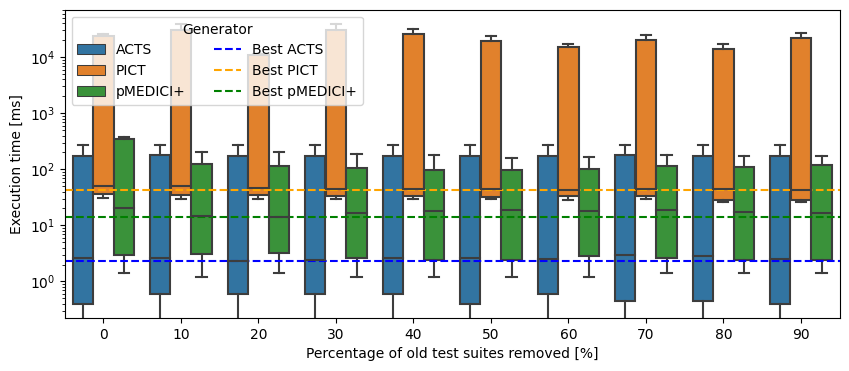

In [13]:
plotByCategory(dfFiltered, 'Time')

Best ACTS (80) - 64.8
Best PICT (80) - 115.0
Best pMEDICI+ (50) - 77.4


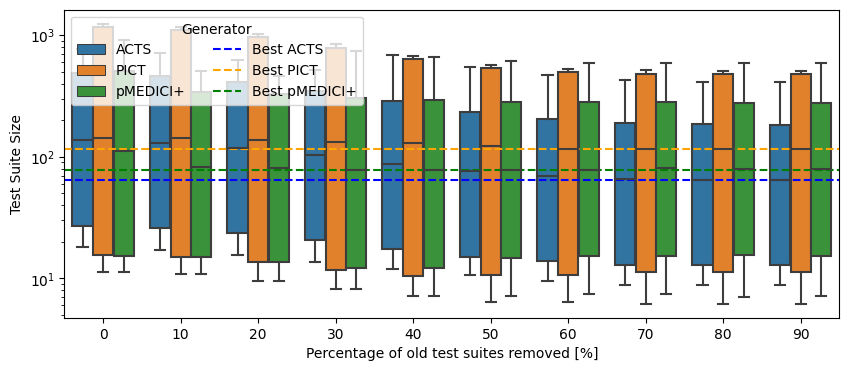

In [14]:
plotByCategory(dfFiltered, 'Size')

## Time analysis

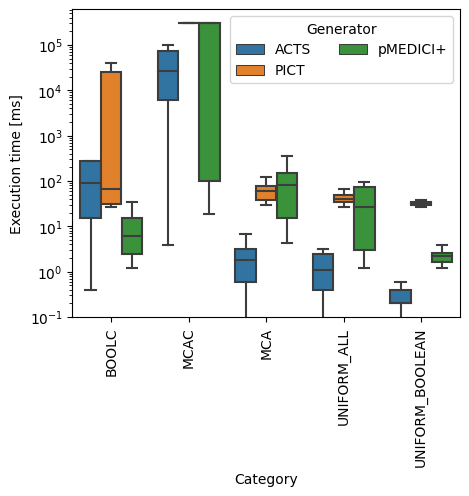

In [15]:
measure = 'Time'

dfFiltered2 = dfFiltered
dfFiltered2.loc[dfFiltered2['ModelName'].str.startswith("MCAC_"), 'ModelName'] = "MCAC"
dfFiltered2.loc[dfFiltered2['ModelName'].str.startswith("BOOLC_"), 'ModelName'] = "BOOLC"
dfFiltered2.loc[dfFiltered2['ModelName'].str.startswith("MCA_"), 'ModelName'] = "MCA"
dfFiltered2.loc[dfFiltered2['ModelName'].str.startswith("UNIFORM_ALL_"), 'ModelName'] = "UNIFORM_ALL"
dfFiltered2.loc[dfFiltered2['ModelName'].str.startswith("UNIFORM_BOOLEAN_"), 'ModelName'] = "UNIFORM_BOOLEAN"

# Remove rows referred to pMEDICI and KALI
dfFiltered2 = dfFiltered2[~ (dfFiltered2['Generator'] ==  'pMEDICI')]
dfFiltered2 = dfFiltered2[~ (dfFiltered2['Generator'] ==  'KALI')]

# Keep only the values for which the percentage of old test suites kept is equal to the best one
dfFiltered2 = dfFiltered2[~ ((dfFiltered2['Generator'] ==  'ACTS') & (~dfFiltered2['PercentageOfOldTsKept'] == 20))]
dfFiltered2 = dfFiltered2[~ ((dfFiltered2['Generator'] ==  'pMEDICI+') & (~dfFiltered2['PercentageOfOldTsKept'] == 20))]
dfFiltered2 = dfFiltered2[~ ((dfFiltered2['Generator'] ==  'PICT') & (~dfFiltered2['PercentageOfOldTsKept'] == 90))]

dfExecutionTime = dfFiltered2[['Generator','TSTime','ModelName','PercentageOfOldTsKept']]
yLabel = 'Execution time [ms]'
yValue = 'TSTime'

# Boxplot the execution time of different generators and remove the outliers
ax = sns.boxplot(x="ModelName", y=yValue,
        hue="Generator",
        data=dfExecutionTime, showfliers=False)
ax.legend(loc='best', ncols=2, title='Generator')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yscale('log')
ax.set_ylabel(yLabel)
ax.set_xlabel('Category')
ax.set_title('')
plt.suptitle('')
# Set the figure size
fig = plt.gcf()
fig.set_size_inches(5, 4)
# Export the figure in PDF
plt.savefig("pictures/TSCP_TS_" + measure + ".pdf", bbox_inches='tight')

In [16]:
# Execute a Wilcoxon Signed-Rank test among each couple of Generators investigating the TSTime
generators = dfExecutionTime['Generator'].unique()
generators = generators[generators != 'pMEDICI']
generators = generators[generators != 'KALI']
dfExecutionTime = dfExecutionTime[~ (dfExecutionTime['PercentageOfOldTsKept'] ==  100)]
for generator1, generator2 in combinations(generators, 2):
    print(generator1 + " VS " + generator2 + ":\n", wilcoxon(dfExecutionTime[dfExecutionTime['Generator'] == generator1]['TSTime'], dfExecutionTime[dfExecutionTime['Generator'] == generator2]['TSTime']))

ACTS VS PICT:
 WilcoxonResult(statistic=2782.0, pvalue=1.592505561027598e-76)
ACTS VS pMEDICI+:
 WilcoxonResult(statistic=35238.0, pvalue=3.736375920813025e-17)
PICT VS pMEDICI+:
 WilcoxonResult(statistic=23742.5, pvalue=1.5369712850402283e-21)


## Size analysis

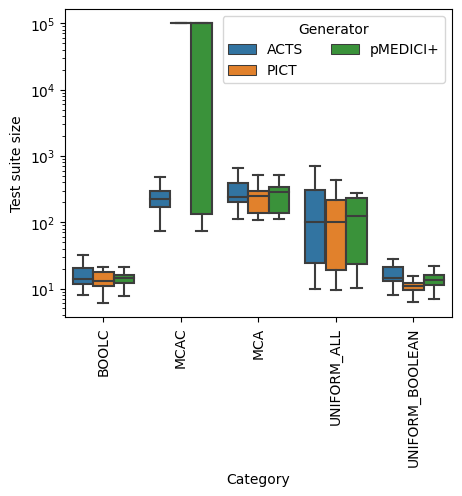

In [17]:
measure = 'Size'

dfFiltered2 = dfFiltered
dfFiltered2.loc[dfFiltered2['ModelName'].str.startswith("MCAC_"), 'ModelName'] = "MCAC"
dfFiltered2.loc[dfFiltered2['ModelName'].str.startswith("BOOLC_"), 'ModelName'] = "BOOLC"
dfFiltered2.loc[dfFiltered2['ModelName'].str.startswith("MCA_"), 'ModelName'] = "MCA"
dfFiltered2.loc[dfFiltered2['ModelName'].str.startswith("UNIFORM_ALL_"), 'ModelName'] = "UNIFORM_ALL"
dfFiltered2.loc[dfFiltered2['ModelName'].str.startswith("UNIFORM_BOOLEAN_"), 'ModelName'] = "UNIFORM_BOOLEAN"

# Remove rows referred to pMEDICI and KALI
dfFiltered2 = dfFiltered2[~ (dfFiltered2['Generator'] ==  'pMEDICI')]
dfFiltered2 = dfFiltered2[~ (dfFiltered2['Generator'] ==  'KALI')]

# Keep only the values for which the percentage of old test suites kept is equal to the best one
dfFiltered2 = dfFiltered2[~ ((dfFiltered2['Generator'] ==  'ACTS') & (~dfFiltered2['PercentageOfOldTsKept'] == 20))]
dfFiltered2 = dfFiltered2[~ ((dfFiltered2['Generator'] ==  'pMEDICI+') & (~dfFiltered2['PercentageOfOldTsKept'] == 20))]
dfFiltered2 = dfFiltered2[~ ((dfFiltered2['Generator'] ==  'PICT') & (~dfFiltered2['PercentageOfOldTsKept'] == 90))]

dfExecutionSize = dfFiltered2[['Generator','TSSize','ModelName','PercentageOfOldTsKept']]
yLabel = 'Test suite size'
yValue = 'TSSize'

# Boxplot the execution time of different generators and remove the outliers
ax = sns.boxplot(x="ModelName", y=yValue,
        hue="Generator",
        data=dfExecutionSize, showfliers=False)
ax.legend(loc='best', ncols=2, title='Generator')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yscale('log')
ax.set_ylabel(yLabel)
ax.set_xlabel('Category')
ax.set_title('')
plt.suptitle('')
# Set the figure size
fig = plt.gcf()
fig.set_size_inches(5, 4)
# Export the figure in PDF
plt.savefig("pictures/TSCP_TS_" + measure + ".pdf", bbox_inches='tight')

In [18]:
# Execute a Wilcoxon Signed-Rank test among each couple of Generators investigating the TSTime
generators = dfExecutionSize['Generator'].unique()
generators = generators[generators != 'pMEDICI']
generators = generators[generators != 'KALI']
dfExecutionSize = dfExecutionSize[~ (dfExecutionSize['PercentageOfOldTsKept'] ==  100)]
for generator1, generator2 in combinations(generators, 2):
    print(generator1 + " VS " + generator2 + ":\n", wilcoxon(dfExecutionSize[dfExecutionSize['Generator'] == generator1]['TSSize'], dfExecutionSize[dfExecutionSize['Generator'] == generator2]['TSSize']))

ACTS VS PICT:
 WilcoxonResult(statistic=60674.0, pvalue=0.5461128846357046)
ACTS VS pMEDICI+:
 WilcoxonResult(statistic=55507.5, pvalue=0.13897208723625076)
PICT VS pMEDICI+:
 WilcoxonResult(statistic=22025.5, pvalue=5.265223327748115e-09)
